In [1]:
import cv2
import numpy as np
import os
from abc import ABC, abstractmethod
from skimage.feature import peak_local_max
import matplotlib.pyplot as plt
import pandas as pd
import imageio.v3 as iio
from typing import Tuple, List, Dict, Optional, Union
from skimage import color

In [2]:
# naming for positions jpg: YY/MM/DD_Positions_CamID.jpg
# naming for template jpg: CamID_ObjectToFind_levelA_template0.jpg
# grayscaling with imageio/skimate/opencv!

In [114]:
class Match(ABC):
    def __init__(self, num_iterations: int, image: np.ndarray, offset: Tuple[int, int]=(0, 0), accuracy: float=1)->None:
        self.num_iterations = num_iterations
        self.offset = offset
        self.accuracy = accuracy
        self.image = image
        
    
    def _get_template_images(self, level:str, filepaths: str)->List:
        return [iio.imread(template) for template in filepaths if 'level'+level in template]
        
        
    def run(self, filepaths: str, level: str='A')->List:
        if self.num_iterations>0:
            self.matches = self._iterate_template_matching(filepaths = filepaths, level=level)
            next_level = 'ABCD'['ABCD'.index(level)+1]
            return [match.run(level=next_level, filepaths=filepaths) for match in self.matches]
        else:
            return self
                
    def _match_template(self, template: np.ndarray) -> Tuple[int, Tuple[int, int]]:
        method = cv2.TM_CCORR_NORMED #cv2.TM_SQDIFF_NORMED, cv2.TM_CCOEFF_NORMED
        result = cv2.matchTemplate(image = self.image, templ = template, method = method)
        return result

    def _iterate_template_matching(self, filepaths: str, level: str)->List:
        if self.num_iterations == 1:
            max_peaks = 1
        else:
            max_peaks = 5
        templates = self._get_template_images(filepaths=filepaths, level=level)
        results_for_heatmap = [self._match_template(template = template) for template in templates]
        template_shape = (max([template.shape[0] for template in templates]), max([template.shape[1] for template in templates]))
        
        if len(results_for_heatmap)!=0:
            pad_length, pad_width = max([result.shape[0] for result in results_for_heatmap]), max([result.shape[1] for result in results_for_heatmap])
            padded_results = [np.pad(result, ((0, pad_length - result.shape[0]), (0, pad_width - result.shape[1]))) for result in results_for_heatmap]
            mean_intensity_values = np.mean(np.array(padded_results), axis=0)
            
            locations = peak_local_max(mean_intensity_values, num_peaks=max_peaks)
            
            matches = []
            if len(locations)!=0:
                for y, x in locations:
                    trimmed_image, new_offset=self._trim_image_get_offset(xy=(x, y), template_shape = template_shape)
                    new_accuracy = mean_intensity_values[y, x]#self.accuracy*
                matches.append(Match(num_iterations=self.num_iterations-1, image=trimmed_image, offset=new_offset, accuracy=new_accuracy))
            return matches

    def _trim_image_get_offset(self, xy: Tuple[int, int], template_shape: Tuple[int, int])->np.ndarray:
        if (template_shape[0]+xy[1])>self.image.shape[0] or (template_shape[1]+xy[0])>self.image.shape[1]:
            return self.image, self.offset
        else:
            trimmed_image = self.image[xy[1]:xy[1]+template_shape[0]+1, xy[0]:xy[0]+template_shape[1]+1]
            if self.num_iterations==1:
                offset = self.offset[0]+xy[0]+template_shape[1]//2, self.offset[1]+xy[1]+template_shape[0]//2
                #template shape for calculating the mean pixel coordinate is not exact!
            else:
                offset = self.offset[0]+xy[0], self.offset[1]+xy[1]
        return trimmed_image, offset
    
class Marker(ABC):
    def __init__(self, marker_id: str, filepaths: List)->None:
        self.marker_id = marker_id
        self.levels = np.unique(np.array([elem[elem.index('level')+5:elem.index('level')+6] for elem in filepaths]))
        self.filepaths = filepaths
    
    def run(self, original_image: np.ndarray)->Tuple[Tuple[int, int], float, str]:
        image = original_image.copy()
        #image = color.rgb2gray(image)
        match = Match(num_iterations=len(self.levels), image=image)
        final_matches = [item[0] for sublist in match.run(filepaths=self.filepaths) for item in sublist]
        
        if len(final_matches)!=0:
            index_best_match = [match.accuracy for match in final_matches].index(max([match.accuracy for match in final_matches]))
            best_match = final_matches[index_best_match]
            best_location_yx = best_match.offset
            likelihood = best_match.accuracy
            best_location_xy = best_location_yx[1], best_location_yx[0]
            coordinates = best_location_yx
            return coordinates, likelihood, self.marker_id
        else:
            print(f'No match found for {self.marker_id}! \n Set likelihood to 0 and position to (0, 0).')
            return (0, 0), 0, self.marker_id

class TemplateMatching(ABC):
    @property
    def template_directory(self) ->str:
        return r"/Users/kobel/Documents/Medizin/Doktorarbeit/Coding/templates_obj/"
    
    @property
    def template_naming(self) ->str:
        return 'template'
    
    @property
    def positions_naming(self) -> str:
        return '_Positions'
    
    
    def __init__(self, directory_positions_jpg: str, cam_id: str, visualize_matching: bool = False):
        self.directory_positions_jpg = directory_positions_jpg
        self.visualize_matching = visualize_matching
        self.cam_id = cam_id
            
    def export_as_DLC_h5(self) -> None:
        df = self._construct_dlc_output_style_df_from_manual_marker_coords()
        if self.visualize_matching:
            print(df)
        output_filepath = f'{self.cam_id}_templatematched_test_position_marker_fake.h5'
        df.to_hdf(output_filepath, "df")
        
        
    def run(self)->None:
        print(f'Now analyzing {self.cam_id}!')
        self.path_positions = self._get_positions_path()
        self.markers = self._get_markers()
        self.original_image = iio.imread(self.path_positions, index=0)
        for marker in self.markers:
            coordinates, likelihood, marker_id = marker.run(original_image=self.original_image)
            self._add_templatematched_test_position_marker(marker_id = marker_id, x_or_column_idx = coordinates[0], y_or_row_idx = coordinates[1], likelihood = likelihood, overwrite = False)
        if self.visualize_matching:
            self._visualize_predictions()
                
    def _add_templatematched_test_position_marker(self, marker_id: str, x_or_column_idx: int, y_or_row_idx: int, likelihood: float, overwrite: bool=False) -> None:
        if hasattr(self, 'manual_test_position_marker_coords_pred') == False:
            self.manual_test_position_marker_coords_pred = {}
        if (marker_id in self.manual_test_position_marker_coords_pred.keys()) & (overwrite == False):
            raise ValueError('There are already coordinates for the marker you '
                             f'tried to add: "{marker_id}: {self.manual_test_position_marker_coords_pred[marker_id]}'
                             '". If you would like to overwrite these coordinates, please pass '
                             '"overwrite = True" as additional argument to this method!')
        self.manual_test_position_marker_coords_pred[marker_id] = {'x': [x_or_column_idx], 'y': [y_or_row_idx], 'likelihood': [likelihood]}
    
    
    def _construct_dlc_output_style_df_from_manual_marker_coords(self) -> pd.DataFrame:
        multi_index = self._get_multi_index()
        df = pd.DataFrame(data = {}, columns = multi_index)
        for scorer, marker_id, key in df.columns:
            df[(scorer, marker_id, key)] = self.manual_test_position_marker_coords_pred[marker_id][key]
        return df
    
    
    def _get_mean_coordinates(self, image: str, template: Tuple[int, int], location: Tuple[int, int]) -> Tuple[int, int]:
        height_template, width_template = template
        center_coordinates = (location[0] + width_template//2, location[0] + height_template//2)
        return center_coordinates
      
    
    def _get_multi_index(self) -> pd.MultiIndex:
        multi_index_column_names = [[], [], []]
        for marker_id in self.manual_test_position_marker_coords_pred.keys():
            for column_name in ("x", "y", "likelihood"):
                multi_index_column_names[0].append("templatematched_marker_positions")
                multi_index_column_names[1].append(marker_id)
                multi_index_column_names[2].append(column_name)
        return pd.MultiIndex.from_arrays(multi_index_column_names, names=('scorer', 'bodyparts', 'coords'))
    
    
    def _get_positions_path(self) -> str:  
        for elem in os.listdir(self.directory_positions_jpg):
            if self.positions_naming in elem and self.cam_id in elem:
                return self.directory_positions_jpg + elem
        if "filepath" not in locals(): 
            raise FileNotFoundError(f'Found no suiting _Positions file for {self.cam_id}!') 
    
    
    def _get_markers(self) -> List:
        all_filepaths = [elem for elem in os.listdir(self.template_directory) if self.template_naming in elem and self.cam_id in elem]
        if len(all_filepaths) == 0:
            raise FileNotFoundError(f'Found no suiting templates for {self.cam_id}')
            
        markers = []
        for filepath in all_filepaths:
            split_name = filepath.split("_")
            marker_id, level = split_name[1], split_name[2]
            if marker_id not in [marker.marker_id for marker in markers]:
                filepaths = [self.template_directory + elem for elem in all_filepaths if marker_id in elem]
                markers.append(Marker(marker_id, filepaths))
        return markers
            
    
    def _visualize_predictions(self)-> None:
        fig = plt.figure(figsize = (20, 10))

        image = iio.imread(self.path_positions, index=0)
        plt.imshow(image)
        for marker in self.markers:
            plt.scatter(self.manual_test_position_marker_coords_pred[marker.marker_id]['x'], self.manual_test_position_marker_coords_pred[marker.marker_id]['y'])
            plt.text(self.manual_test_position_marker_coords_pred[marker.marker_id]['x'][0], self.manual_test_position_marker_coords_pred[marker.marker_id]['y'][0], marker.marker_id)
        plt.show()

Now analyzing Side1!
No match found for MazeCornerOpenLeft! 
 Set likelihood to 0 and position to (0, 0).


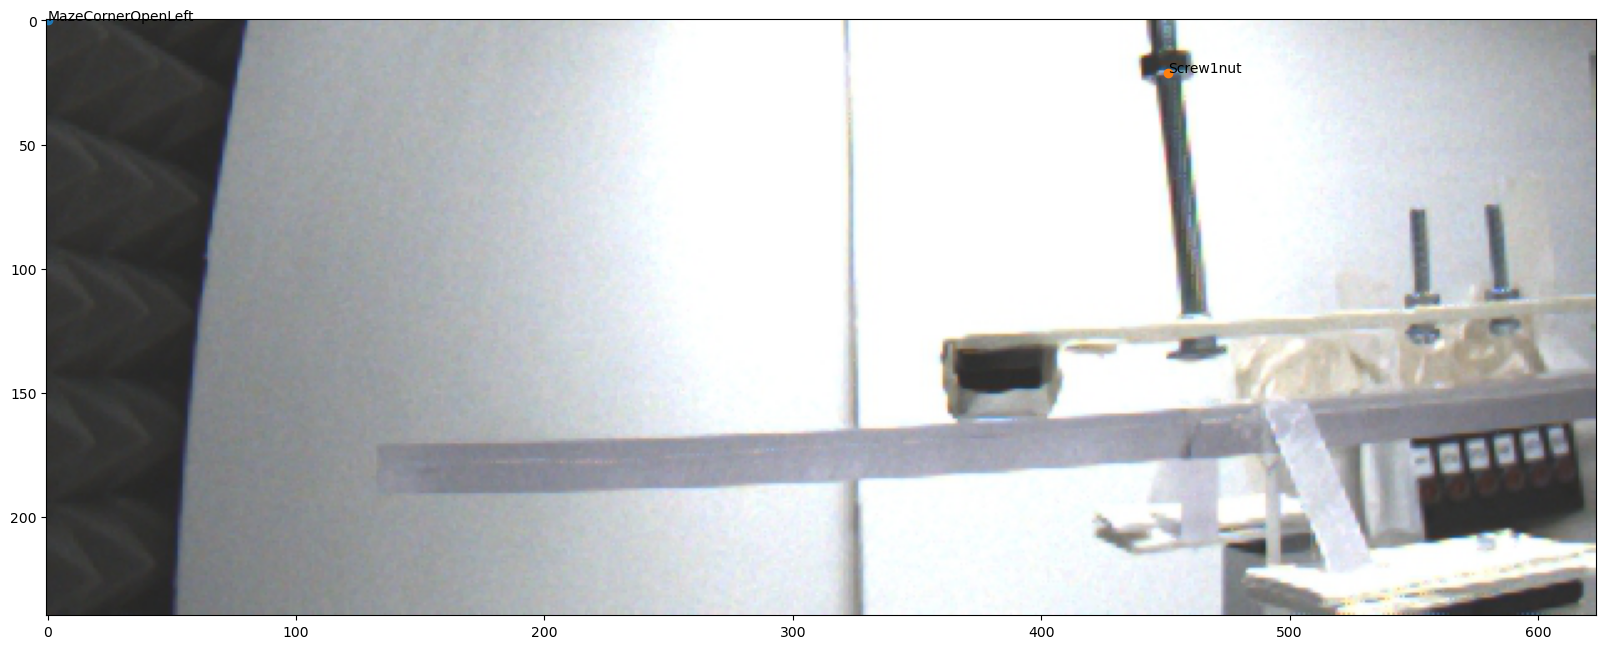

scorer    templatematched_marker_positions                              \
bodyparts               MazeCornerOpenLeft               Screw1nut       
coords                                   x  y likelihood         x   y   
0                                        0  0          0       451  21   

scorer                
bodyparts             
coords    likelihood  
0           0.941443  


In [115]:
Side1_220826 = TemplateMatching(directory_positions_jpg = '/Users/kobel/Documents/Medizin/Doktorarbeit/Coding/positions/220826/', cam_id = "Side1", visualize_matching= True)
Side1_220826.run()
Side1_220826.export_as_DLC_h5()

In [113]:
Top_220826 = TemplateMatching(directory_positions_jpg = '/Users/kobel/Documents/Medizin/Doktorarbeit/Coding/positions/220826/', cam_id = "Top", visualize_matching= True)
Top_220826.run()
Side2_220826 = TemplateMatching(directory_positions_jpg = '/Users/kobel/Documents/Medizin/Doktorarbeit/Coding/positions/220826/', cam_id = "Side2", visualize_matching= True)
Side2_220826.run()
Ground1_220826 = TemplateMatching(directory_positions_jpg = '/Users/kobel/Documents/Medizin/Doktorarbeit/Coding/positions/220826/', cam_id = "Ground1", visualize_matching= True)
Ground1_220826.run()
Bottom_220826 = TemplateMatching(directory_positions_jpg = '/Users/kobel/Documents/Medizin/Doktorarbeit/Coding/positions/220826/', cam_id = "Bottom", visualize_matching= True)
Bottom_220826.run()
Ground2_220826 = TemplateMatching(directory_positions_jpg = '/Users/kobel/Documents/Medizin/Doktorarbeit/Coding/positions/220826/', cam_id = "Ground2", visualize_matching= True)
Ground2_220826.run()

Now analyzing Top!


FileNotFoundError: Found no suiting templates for Top